In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import re

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
seed = 538

In [4]:
WORKING_DIRECTORY = 'D:/Fire Project/data/'

## Incident counts, weighted by population

We'll start by downloading the total 2020 population counts for US incorporated places and minor encorporated places: April 1 2020 to July 1 2021 from [the Census.gov website](https://www.census.gov/data/tables/time-series/demo/popest/2020s-total-cities-and-towns.html). [Direct link.](https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/cities/totals/sub-est2021_all.csv)

In [5]:
pop_counts = pd.read_csv(WORKING_DIRECTORY + 'sub-est2021_all.csv',
                         sep=',',
                         encoding='ISO-8859-1')
pop_counts.sample()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021
8753,162,17,0,51206,0,0,0,A,Mount Zion village,Illinois,5987,5973,5920


In [6]:
pop_counts = pop_counts.loc[:, ['PLACE', 'NAME', 'STNAME', 'ESTIMATESBASE2020']]

In [7]:
pop_counts['NAME'] = pop_counts.NAME \
                                .str \
                                .upper()

The state data is spelled out, so we'll split and convert to state codes.

In [8]:
state_dict = {
    "ALABAMA": "AL",
    "ALASKA": "AK",
    "ARIZONA": "AZ",
    "ARKANSAS": "AR",
    "CALIFORNIA": "CA",
    "COLORADO": "CO",
    "CONNECTICUT": "CT",
    "DELAWARE": "DE",
    "FLORIDA": "FL",
    "GEORGIA": "GA",
    "HAWAII": "HI",
    "IDAHO": "ID",
    "ILLINOIS": "IL",
    "INDIANA": "IN",
    "IOWA": "IA",
    "KANSAS": "KS",
    "KENTUCKY": "KY",
    "LOUISIANA": "LA",
    "MAINE": "ME",
    "MARYLAND": "MD",
    "MASSACHUSETTS": "MA",
    "MICHIGAN": "MI",
    "MINNESOTA": "MN",
    "MISSISSIPPI": "MS",
    "MISSOURI": "MO",
    "MONTANA": "MT",
    "NEBRASKA": "NE",
    "NEVADA": "NV",
    "NEW HAMPSHIRE": "NH",
    "NEW JERSEY": "NJ",
    "NEW MEXICO": "NM",
    "NEW YORK": "NY",
    "NORTH CAROLINA": "NC",
    "NORTH DAKOTA": "ND",
    "OHIO": "OH",
    "OKLAHOMA": "OK",
    "OREGON": "OR",
    "PENNSYLVANIA": "PA",
    "RHODE ISLAND": "RI",
    "SOUTH CAROLINA": "SC",
    "SOUTH DAKOTA": "SD",
    "TENNESSEE": "TN",
    "TEXAS": "TX",
    "UTAH": "UT",
    "VERMONT": "VT",
    "VIRGINIA": "VA",
    "WASHINGTON": "WA",
    "WEST VIRGINIA": "WV",
    "WISCONSIN": "WI",
    "WYOMING": "WY"
}


In [9]:
pop_counts['STNAME'] = pop_counts.STNAME \
                                    .str \
                                    .upper() \
                                    .map(state_dict)

In [10]:
state_names = state_dict.keys()
state_codes = state_dict.values()

name_mask = pop_counts['NAME'].isin(state_names)
code_mask = pop_counts['STNAME'].isin(state_codes)

pop_counts = pop_counts[~name_mask | ~code_mask]

In [11]:
pop_counts = pop_counts[~pop_counts['NAME'].str.endswith('COUNTY')]

We'll drop the parts for this analysis.

In [12]:
pop_counts = pop_counts[~pop_counts['NAME'].str.endswith('(PT.)')]

In [13]:
patterns = [
    re.compile(r'\b\sCITY\b(?!\s*\b\sCITY\b)', re.IGNORECASE),
    re.compile(r'\b\sBOROUGH\b(?!\s*\b\sBOROUGH\b)', re.IGNORECASE),
    re.compile(r'\b\sVILLAGE\b(?!\s*\b\sVILLAGE\b)', re.IGNORECASE),
    re.compile(r'\b\sTOWN\b(?!\s*\b\sTOWN\b)', re.IGNORECASE),
    re.compile(r'\b\sTOWNSHIP\b(?!\s*\b\sTOWNSHIP\b)', re.IGNORECASE)
    ]

for pattern in patterns:
    pop_counts['NAME'] = pop_counts['NAME'].apply(lambda x: pattern.sub('', str(x)))

In [14]:
pop_counts['CITYSTATE'] = pop_counts['NAME'].str.upper() + ',' + pop_counts['STNAME'].str.upper()

In [15]:
pop_counts = pop_counts[pop_counts.ESTIMATESBASE2020 > 0]

In [16]:
pop_counts = pop_counts[~pop_counts.duplicated()]

In [17]:
conn = sqlite3.Connection(WORKING_DIRECTORY + 'fire_data.db')

In [18]:
total_inc_counts = pd.read_sql("""
    SELECT ia.CITY || ',' || ia.STATE 
                AS CITYSTATE, 
            COUNT(bi.ID) AS INC_COUNT
    FROM basic_incident bi JOIN incident_address ia
        USING (INCIDENT_KEY)
    WHERE bi.INC_TYPE < 200
        AND CAST(SUBSTR(ia.INC_DATE, LENGTH(ia.INC_DATE) - 3, 4) AS INTEGER) < 2019
    GROUP BY ia.CITY, ia.STATE
""", conn)

In [ ]:
total_inc_pop = total_inc_counts.merge(pop_counts, 
                                       how='inner', 
                                       on='CITYSTATE')

In [ ]:
total_inc_pop = total_inc_pop.sort_values(['PLACE', 'ESTIMATESBASE2020'], 
                                            ascending=[True, False])

total_inc_pop = total_inc_pop.drop_duplicates(subset='PLACE', keep='first')

In [ ]:
total_inc_pop['INC_COUNT_ADJ'] = total_inc_pop.INC_COUNT / total_inc_pop.ESTIMATESBASE2020

In [ ]:
total_inc_pop.to_csv(path_or_buf=WORKING_DIRECTORY + 'total_inc_pop.csv',
                     sep=',',
                     index=False)

# Incident counts by incident type (population adjusted)

In [ ]:
inc_type_counts = pd.read_sql("""
    SELECT ia.CITY || ',' || ia.STATE 
                AS CITYSTATE, 
            bi.INC_TYPE 
                AS INC_TYPE,
            COUNT(bi.ID) 
                AS INC_COUNT
    FROM basic_incident bi JOIN incident_address ia
        USING (INCIDENT_KEY)
    WHERE bi.INC_TYPE < 200 
        AND CAST(SUBSTR(ia.INC_DATE, LENGTH(ia.INC_DATE) - 3, 4) AS INTEGER) < 2019
    GROUP BY ia.CITY, ia.STATE, bi.INC_TYPE
""", conn)

In [ ]:
inc_type_pop = inc_type_counts.merge(pop_counts, 
                                       how='inner', 
                                       on='CITYSTATE')

Let's look at the most common incident types in our dataset.

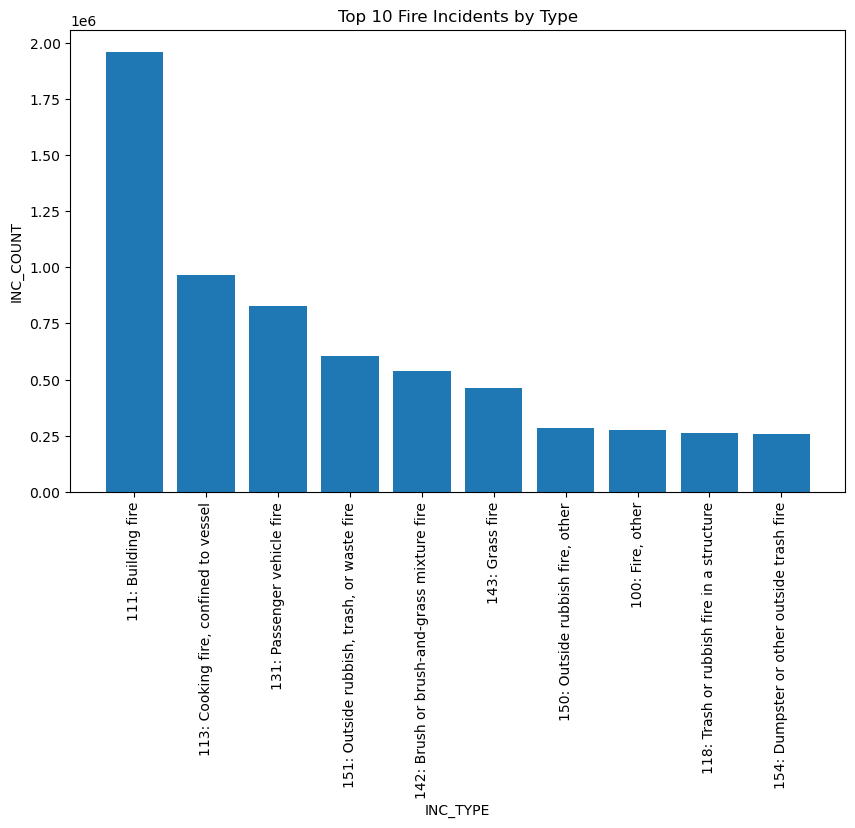

In [ ]:
grouped_data = inc_type_pop.groupby('INC_TYPE')['INC_COUNT'].sum().reset_index()

sorted_data = grouped_data.sort_values('INC_COUNT', ascending=False)

# Get top 10 incident types
top_10_data = sorted_data.head(10).copy()  # Create a copy of the data to avoid warnings

inc_type_descriptions = {
    111: 'Building fire',
    113: 'Cooking fire, confined to vessel',
    131: 'Passenger vehicle fire',
    151: 'Outside rubbish, trash, or waste fire',
    142: 'Brush or brush-and-grass mixture fire',
    143: 'Grass fire',
    150: 'Outside rubbish fire, other',
    100: 'Fire, other',
    118: 'Trash or rubbish fire in a structure',
    154: 'Dumpster or other outside trash fire',
}

top_10_data.loc[:, 'INC_TYPE_DESC'] = top_10_data['INC_TYPE'].map(inc_type_descriptions)

top_10_data.loc[:, 'INC_TYPE_WITH_DESC'] = top_10_data['INC_TYPE'].astype(str) + ': ' + top_10_data['INC_TYPE_DESC']

plt.figure(figsize=(10, 6))
plt.bar(top_10_data['INC_TYPE_WITH_DESC'], top_10_data['INC_COUNT'])
plt.xlabel('INC_TYPE')
plt.ylabel('INC_COUNT')
plt.title('Top 10 Fire Incidents by Type')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
inc_type_pop111 = inc_type_pop[inc_type_pop.INC_TYPE == 111].copy()
inc_type_pop111.loc[:, '111_COUNT_ADJ'] = inc_type_pop111.INC_COUNT / inc_type_pop111.ESTIMATESBASE2020

In [ ]:
inc_type_pop113 = inc_type_pop[inc_type_pop.INC_TYPE == 113].copy()
inc_type_pop113.loc[:, '113_COUNT_ADJ'] = inc_type_pop113.INC_COUNT / inc_type_pop113.ESTIMATESBASE2020

In [ ]:
inc_type_pop111.to_csv(path_or_buf=WORKING_DIRECTORY + 'inc_type_pop111_pre2019.csv',
                     sep=',',
                     index=False)

inc_type_pop113.to_csv(path_or_buf=WORKING_DIRECTORY + 'inc_type_pop113_pre2019.csv',
                     sep=',',
                     index=False)

### Check why some states are getting dropped when merging pop_counts and total_inc_counts

### Total incident count by year and city, adjusted for population